In [ ]:
import pandas as pd
import numpy as np

In [ ]:
# Reload libraries without SHAP to avoid dependency errors
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
from sklearn.feature_selection import chi2, SelectKBest
from sklearn.ensemble import VotingClassifier, RandomForestClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression


In [ ]:
df = pd.read_csv('hybrid.csv')
print("Heart Statlog Cleveland Hungary Final Dataset:")
print(df.head())

Heart Statlog Cleveland Hungary Final Dataset:
   age  sex  chest pain type  resting bp s  cholesterol  fasting blood sugar  \
0   40    1                2           140          289                    0   
1   49    0                3           160          180                    0   
2   37    1                2           130          283                    0   
3   48    0                4           138          214                    0   
4   54    1                3           150          195                    0   

   resting ecg  max heart rate  exercise angina  oldpeak  ST slope  target  
0            0             172                0      0.0         1       0  
1            0             156                0      1.0         2       1  
2            1              98                0      0.0         1       0  
3            0             108                1      1.5         2       1  
4            0             122                0      0.0         1       0  


In [ ]:
# Check for missing values and data types in both datasets
print("Heart Statlog Cleveland Hungary Final Dataset Info:")
# Check for missing values and data types
df_info = pd.DataFrame({
    'Data Type': df.dtypes,
    'Missing Values': df.isnull().sum(),
    'Unique Values': df.nunique()
})

df_info


Heart Statlog Cleveland Hungary Final Dataset Info:


Data Type  Missing Values  Unique Values
age                     int64               0             50
sex                     int64               0              2
chest pain type         int64               0              4
resting bp s            int64               0             67
cholesterol             int64               0            222
fasting blood sugar     int64               0              2
resting ecg             int64               0              3
max heart rate          int64               0            119
exercise angina         int64               0              2
oldpeak               float64               0             53
ST slope                int64               0              4
target                  int64               0              2

In [ ]:
df.describe().T

count        mean         std   min    25%    50%  \
age                  1190.0   53.720168    9.358203  28.0   47.0   54.0   
sex                  1190.0    0.763866    0.424884   0.0    1.0    1.0   
chest pain type      1190.0    3.232773    0.935480   1.0    3.0    4.0   
resting bp s         1190.0  132.153782   18.368823   0.0  120.0  130.0   
cholesterol          1190.0  210.363866  101.420489   0.0  188.0  229.0   
fasting blood sugar  1190.0    0.213445    0.409912   0.0    0.0    0.0   
resting ecg          1190.0    0.698319    0.870359   0.0    0.0    0.0   
max heart rate       1190.0  139.732773   25.517636  60.0  121.0  140.5   
exercise angina      1190.0    0.387395    0.487360   0.0    0.0    0.0   
oldpeak              1190.0    0.922773    1.086337  -2.6    0.0    0.6   
ST slope             1190.0    1.624370    0.610459   0.0    1.0    2.0   
target               1190.0    0.528571    0.499393   0.0    0.0    1.0   

                        75%    max  
age                   60.00   77.0  
sex                    1.00    1.0  
chest pain type        4.00    4.0  
resting bp s         140.00  200.0  
cholesterol          269.75  603.0  
fasting blood sugar    0.00    1.0  
resting ecg            2.00    2.0  
max heart rate       160.00  202.0  
exercise angina        1.00    1.0  
oldpeak                1.60    6.2  
ST slope               2.00    3.0  
target                 1.00    1.0

In [ ]:
# Check for duplicates
duplicates = df.duplicated().sum()

# Summary of duplicate rows
duplicates


272

In [ ]:
# Remove duplicates
data = df.drop_duplicates().reset_index(drop=True)

# Confirm removal of duplicates
data.shape


(918, 12)

In [ ]:
# Function to detect and remove outliers using IQR
def remove_outliers_iqr(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df

# List of clinical features to check for outliers
clinical_features = ['resting bp s', 'cholesterol', 'max heart rate', 'oldpeak']

# Remove outliers
data_clean = remove_outliers_iqr(data, clinical_features)

# Check new shape after removing outliers
data_clean.shape


(701, 12)

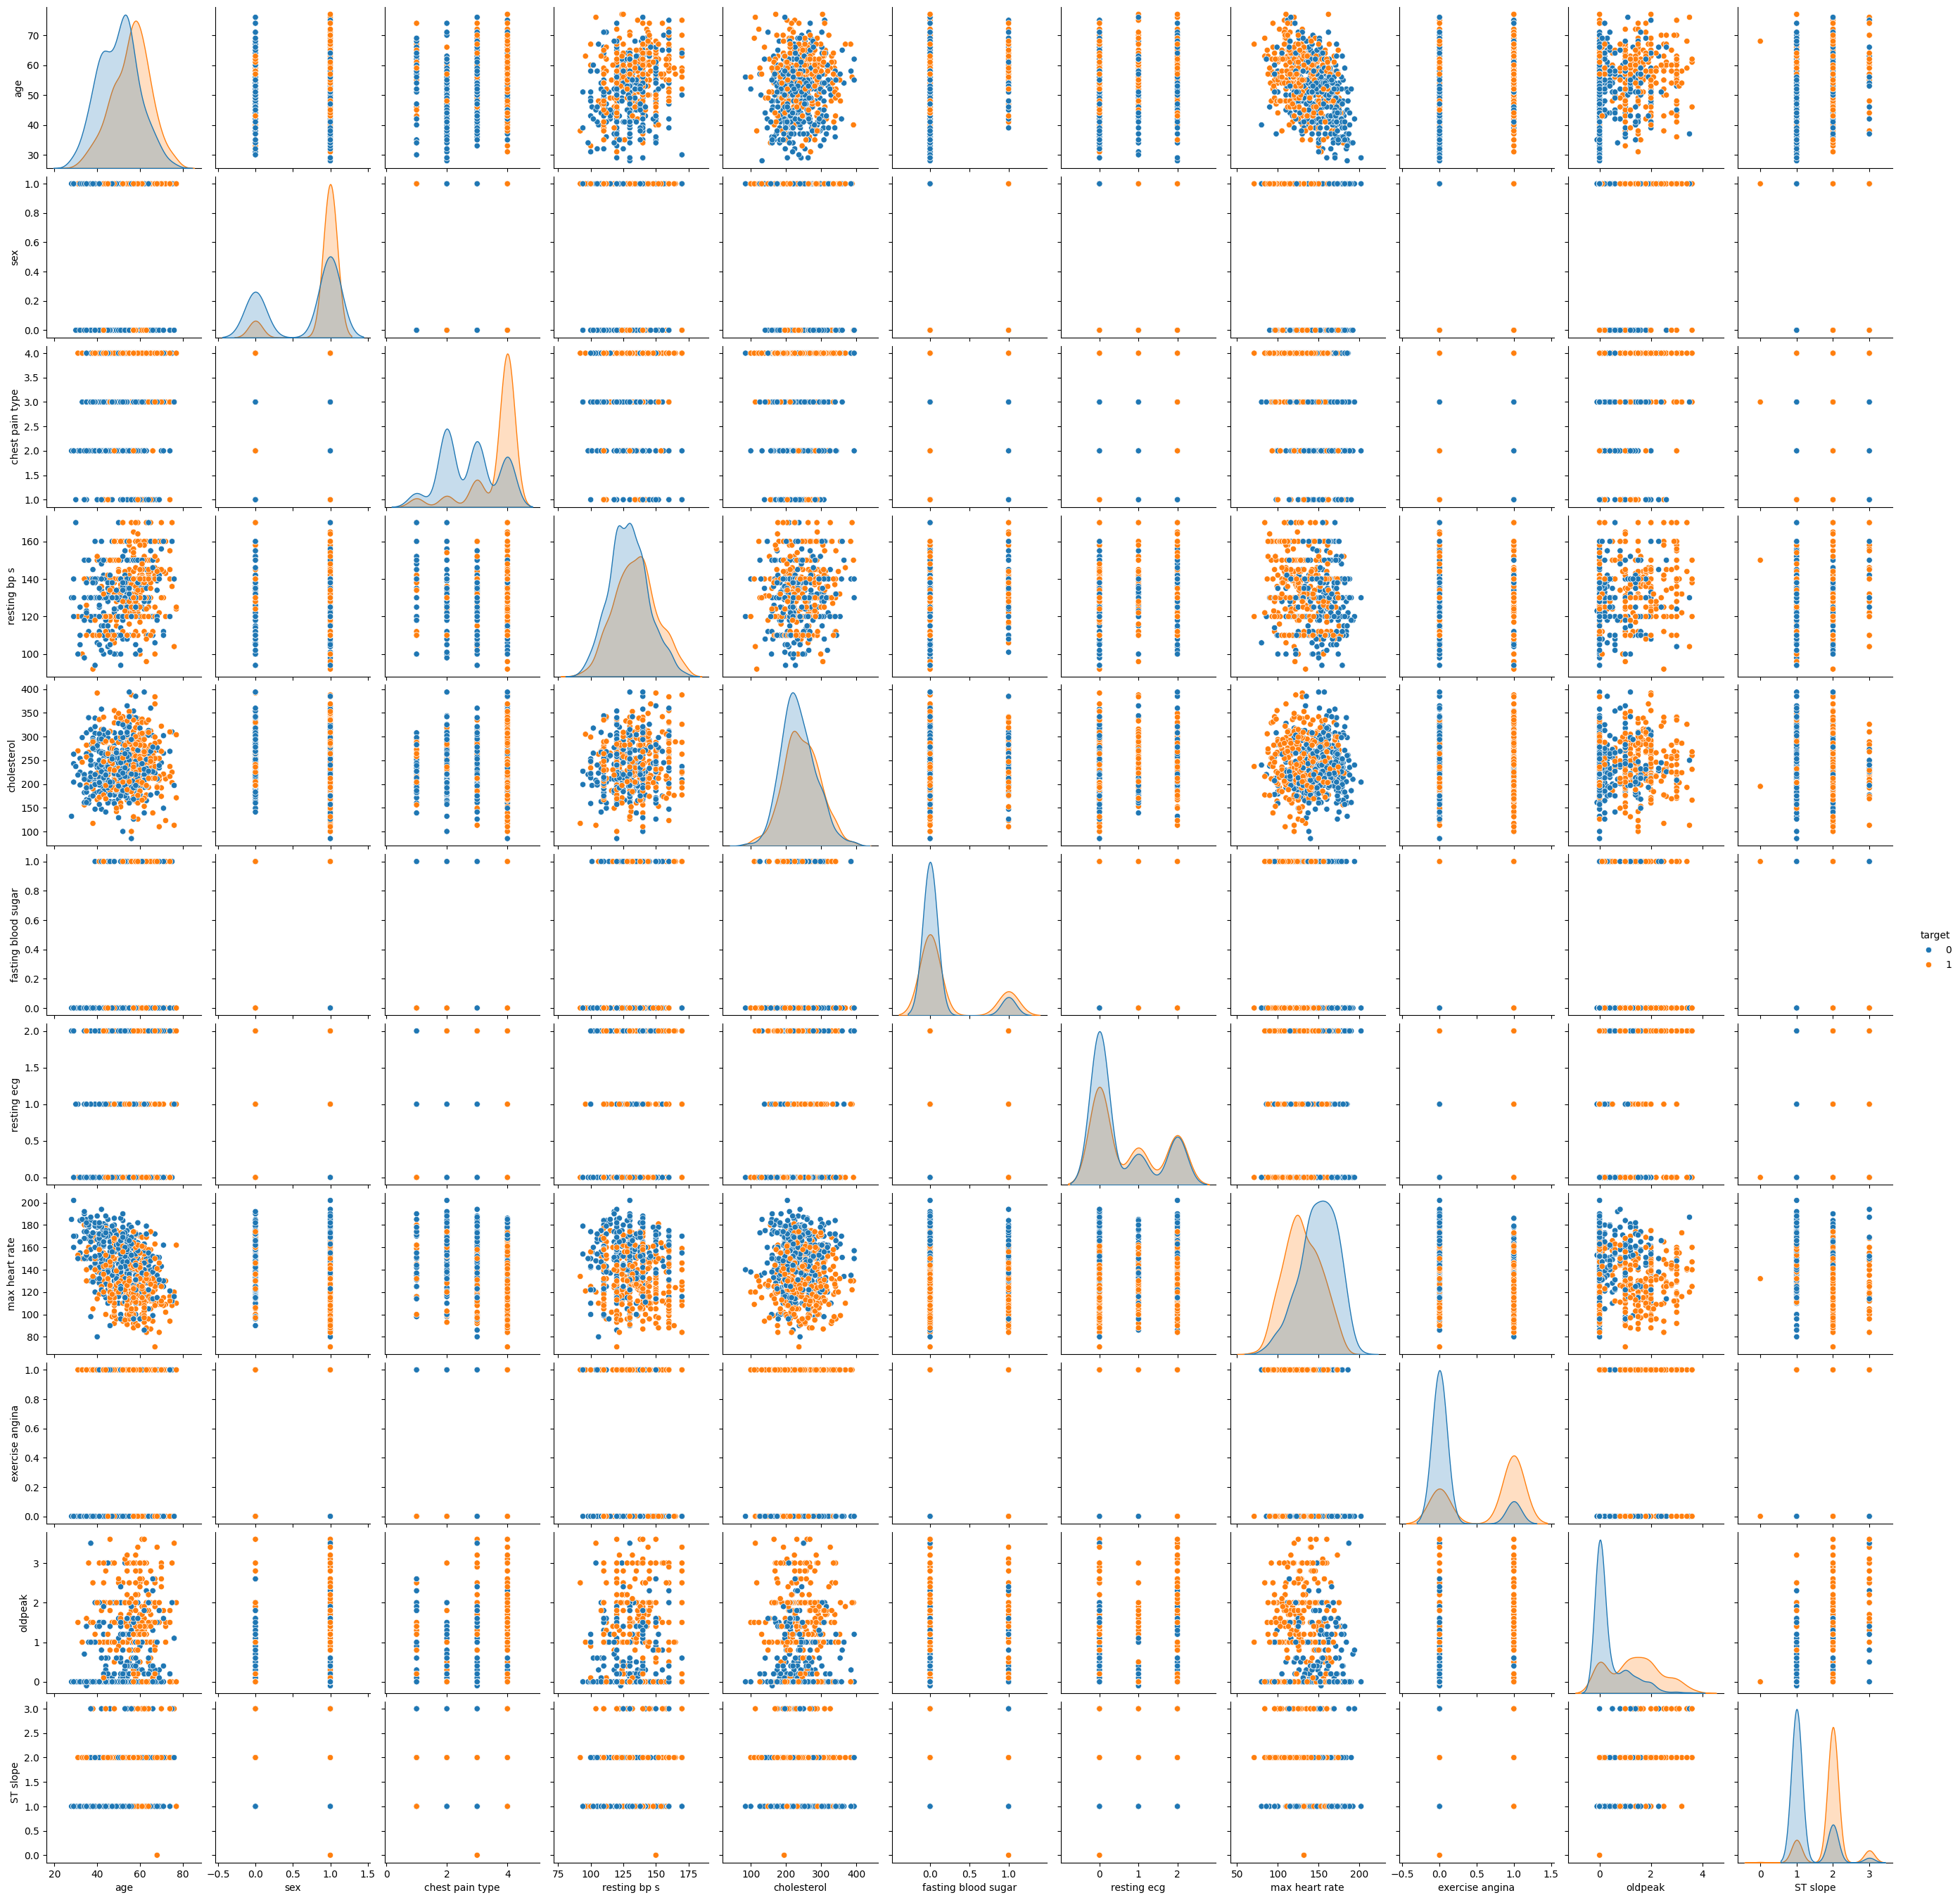

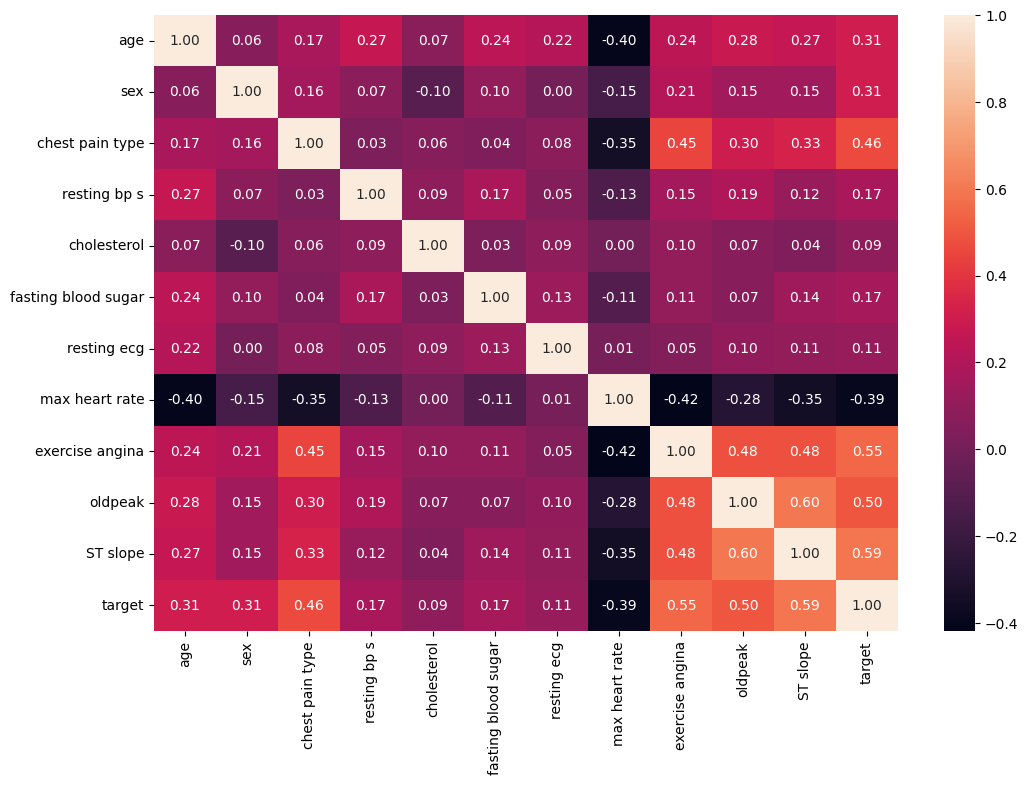

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Pairplot for Hybrid dataset
sns.pairplot(data_clean, hue='target')
plt.show()

# Correlation matrix for Hybrid dataset
plt.figure(figsize=(12, 8))
sns.heatmap(data_clean.corr(), annot=True, fmt=".2f")
plt.show()

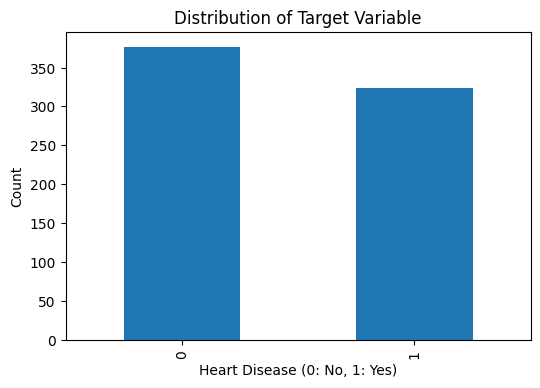

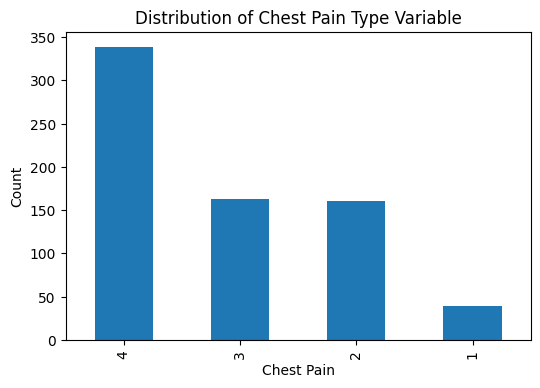

In [ ]:
import matplotlib.pyplot as plt

# Target variable distribution
plt.figure(figsize=(6, 4))
data_clean['target'].value_counts().plot(kind='bar')
plt.title("Distribution of Target Variable")
plt.xlabel("Heart Disease (0: No, 1: Yes)")
plt.ylabel("Count")
plt.show()

# Cholesterol variable distribution
plt.figure(figsize=(6, 4))
data_clean['chest pain type'].value_counts().plot(kind='bar')
plt.title("Distribution of Chest Pain Type Variable")
plt.xlabel("Chest Pain")
plt.ylabel("Count")
plt.show()


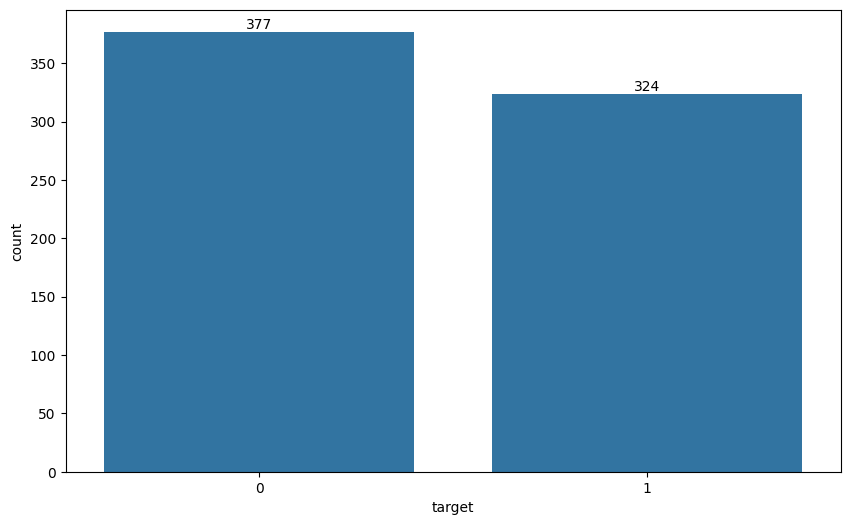

target
0    377
1    324
Name: count, dtype: int64
chest pain type
4    339
3    163
2    160
1     39
Name: count, dtype: int64


In [ ]:
plt.figure(figsize=(10,6))
ax = sns.countplot(data=data_clean, x='target')

# Display the counts on top of the bars
ax.bar_label(ax.containers[0])

plt.show()

print(data_clean['target'].value_counts())
print(data_clean['chest pain type'].value_counts())

In [ ]:
print(data_clean['target'].value_counts())

target
0    377
1    324
Name: count, dtype: int64


In [ ]:
data_clean.describe().T

count        mean        std   min    25%    50%    75%  \
age                  701.0   52.723252   9.542111  28.0   46.0   54.0   59.0   
sex                  701.0    0.760342   0.427179   0.0    1.0    1.0    1.0   
chest pain type      701.0    3.144080   0.956517   1.0    2.0    3.0    4.0   
resting bp s         701.0  131.544936  15.428074  92.0  120.0  130.0  140.0   
cholesterol          701.0  239.475036  50.338211  85.0  206.0  235.0  272.0   
fasting blood sugar  701.0    0.162625   0.369287   0.0    0.0    0.0    0.0   
resting ecg          701.0    0.634807   0.838801   0.0    0.0    0.0    1.0   
max heart rate       701.0  140.573466  24.370341  71.0  122.0  140.0  160.0   
exercise angina      701.0    0.373752   0.484144   0.0    0.0    0.0    1.0   
oldpeak              701.0    0.829244   0.959398  -0.1    0.0    0.4    1.5   
ST slope             701.0    1.560628   0.583919   0.0    1.0    2.0    2.0   
target               701.0    0.462197   0.498925   0.0    0.0    0.0    1.0   

                       max  
age                   77.0  
sex                    1.0  
chest pain type        4.0  
resting bp s         170.0  
cholesterol          394.0  
fasting blood sugar    1.0  
resting ecg            2.0  
max heart rate       202.0  
exercise angina        1.0  
oldpeak                3.6  
ST slope               3.0  
target                 1.0

In [ ]:
from sklearn.model_selection import train_test_split

# Define features (X) and target (y)
X = data_clean.drop(columns=['target'])
y = data_clean['target']

# Perform the split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.33, random_state=42, stratify=y_temp)

# Check the split ratios
train_ratio = len(X_train) / len(data_clean)
test_ratio = len(X_test) / len(data_clean)
val_ratio = len(X_val) / len(data_clean)

train_ratio, test_ratio, val_ratio


(0.6990014265335235, 0.20114122681883023, 0.09985734664764621)

In [ ]:
# Splitting data into features (X) and target (y)
X = data_clean.drop('target', axis=1)
y = data_clean['target']

# Standardize numerical features
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# Split the data
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y, test_size=0.3, random_state=42, stratify=y)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.33, random_state=42, stratify=y_temp)

# Display shapes of the splits
(X_train.shape, y_train.shape), (X_test.shape, y_test.shape), (X_val.shape, y_val.shape)


(((490, 11), (490,)), ((141, 11), (141,)), ((70, 11), (70,)))

In [ ]:
# Feature Selection using Chi-Square Test
# Replace chi2 with a different scoring function suitable for negative data
# like f_classif (ANOVA F-value) or mutual_info_classif (mutual information)
from sklearn.feature_selection import f_classif, SelectKBest

# Initialize SelectKBest with f_classif
chi2_selector = SelectKBest(f_classif, k="all")  # Select all features

X_train_selected = chi2_selector.fit_transform(X_train, y_train)
X_test_selected = chi2_selector.transform(X_test)
X_val_selected = chi2_selector.transform(X_val)

# Get selected feature indices
selected_features = X_train.columns[chi2_selector.get_support()]

# Display selected features
selected_features

Index(['age', 'sex', 'chest pain type', 'resting bp s', 'cholesterol',
       'fasting blood sugar', 'resting ecg', 'max heart rate',
       'exercise angina', 'oldpeak', 'ST slope'],
      dtype='object')

In [ ]:
# Models to train
models = {
    "Naive Bayes": GaussianNB(),
    "SVM": SVC(probability=True),
    "Logistic Regression": LogisticRegression(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "KNN": KNeighborsClassifier(),
    "Bagging": BaggingClassifier(),
    "AdaBoost": AdaBoostClassifier(),
    "XGBoost": RandomForestClassifier(),
    "Voting Classifier": VotingClassifier(
        estimators=[
            ('lr', LogisticRegression()),
            ('rf', RandomForestClassifier()),
            ('svc', SVC(probability=True))
        ],
        voting='soft'
    )
}

# Train and evaluate models
results = []
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None

    # Metrics
    acc = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba) if y_proba is not None else "N/A"

    results.append([name, acc, precision, recall, f1, auc])

# Convert results to DataFrame
results_df = pd.DataFrame(results, columns=["Model", "Accuracy", "Precision", "Recall", "F1-Score", "AUC"])
results_df.sort_values(by="Accuracy", ascending=False, inplace=True)

# Instead of using ace_tools, display the DataFrame using pandas' display function
display(results_df)
# or print the DataFrame
print(results_df)

Model  Accuracy  Precision    Recall  F1-Score       AUC
4        Random Forest  0.851064   0.833333  0.846154  0.839695  0.905466
6              Bagging  0.851064   0.833333  0.846154  0.839695  0.885628
8              XGBoost  0.851064   0.843750  0.830769  0.837209  0.901721
7             AdaBoost  0.829787   0.815385  0.815385  0.815385  0.886437
0          Naive Bayes  0.808511   0.771429  0.830769  0.800000  0.879555
1                  SVM  0.808511   0.771429  0.830769  0.800000  0.876923
9    Voting Classifier  0.808511   0.779412  0.815385  0.796992  0.891700
2  Logistic Regression  0.801418   0.768116  0.815385  0.791045  0.878745
5                  KNN  0.780142   0.736111  0.815385  0.773723  0.835324
3        Decision Tree  0.737589   0.700000  0.753846  0.725926  0.738765

                 Model  Accuracy  Precision    Recall  F1-Score       AUC
4        Random Forest  0.851064   0.833333  0.846154  0.839695  0.905466
6              Bagging  0.851064   0.833333  0.846154  0.839695  0.885628
8              XGBoost  0.851064   0.843750  0.830769  0.837209  0.901721
7             AdaBoost  0.829787   0.815385  0.815385  0.815385  0.886437
0          Naive Bayes  0.808511   0.771429  0.830769  0.800000  0.879555
1                  SVM  0.808511   0.771429  0.830769  0.800000  0.876923
9    Voting Classifier  0.808511   0.779412  0.815385  0.796992  0.891700
2  Logistic Regression  0.801418   0.768116  0.815385  0.791045  0.878745
5                  KNN  0.780142   0.736111  0.815385  0.773723  0.835324
3        Decision Tree  0.737589   0.700000  0.753846  0.725926  0.738765


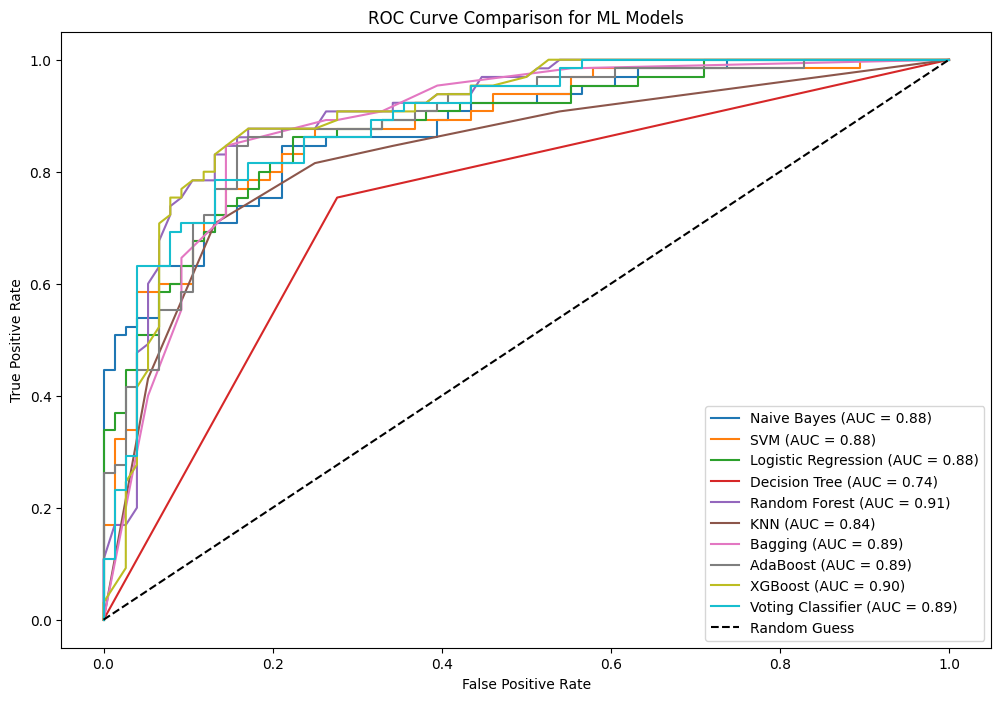

In [ ]:
from sklearn.metrics import roc_curve, auc

# Plot ROC Curve for all models
plt.figure(figsize=(12, 8))

for name, model in models.items():
    if hasattr(model, "predict_proba"):  # Only models with predict_proba
        y_proba = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

# Plot reference line
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')

# Final plot adjustments
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison for ML Models')
plt.legend(loc="lower right")
plt.show()


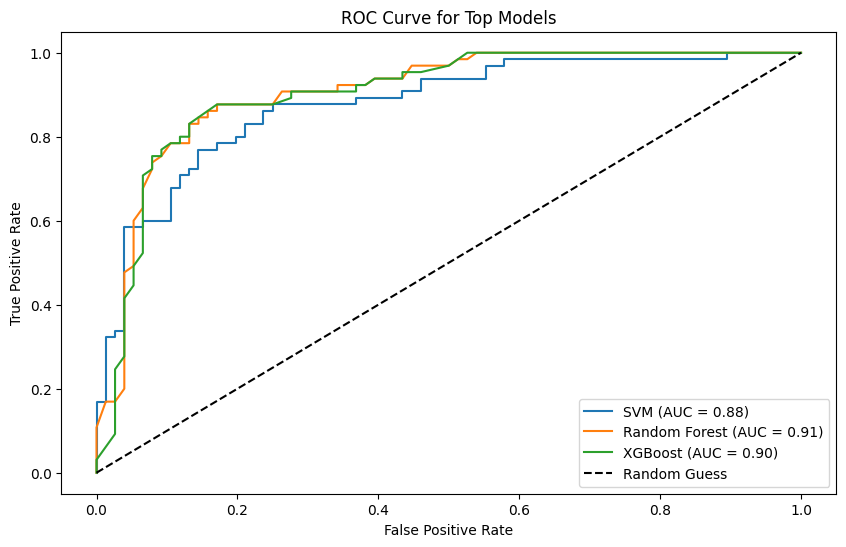

In [ ]:
# Plot ROC Curve for Top Models Only
top_models = ["Random Forest", "XGBoost", "SVM"]
plt.figure(figsize=(10, 6))

for name, model in models.items():
    if name in top_models and hasattr(model, "predict_proba"):  # Only top models with predict_proba
        y_proba = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

# Plot reference line
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')

# Final plot adjustments
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Top Models')
plt.legend(loc="lower right")
plt.show()


In [ ]:
# Feature Importance for the Top Model (Random Forest)

# Random Forest is the top-performing model
top_model = RandomForestClassifier()
top_model.fit(X_train, y_train)

# Feature Importance from the Random Forest Model
feature_importances = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': top_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Instead of using 'tools', directly display the DataFrame
print("Feature Importance (Random Forest):")
print(feature_importances)  # Or use 'display(feature_importances)' for a richer output in Jupyter

Feature Importance (Random Forest):
                Feature  Importance
10             ST slope    0.226604
9               oldpeak    0.128473
8       exercise angina    0.111081
7        max heart rate    0.110481
2       chest pain type    0.109090
0                   age    0.079727
4           cholesterol    0.075833
3          resting bp s    0.066902
1                   sex    0.052279
6           resting ecg    0.025259
5   fasting blood sugar    0.014272


**Tree Generation**

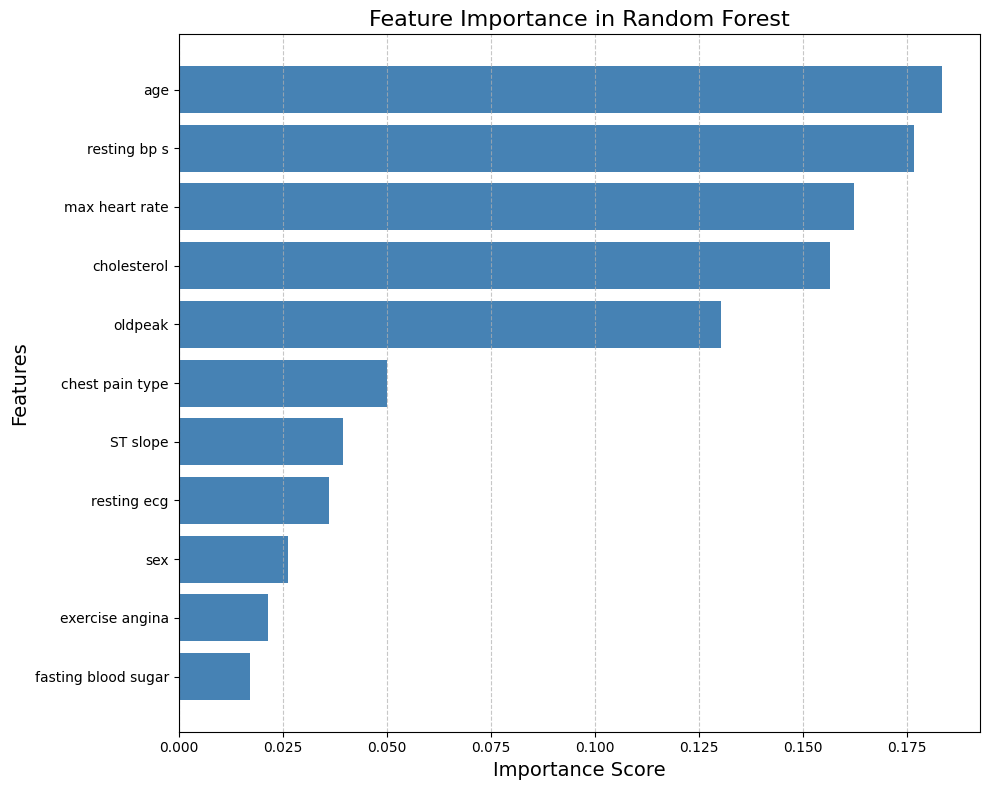

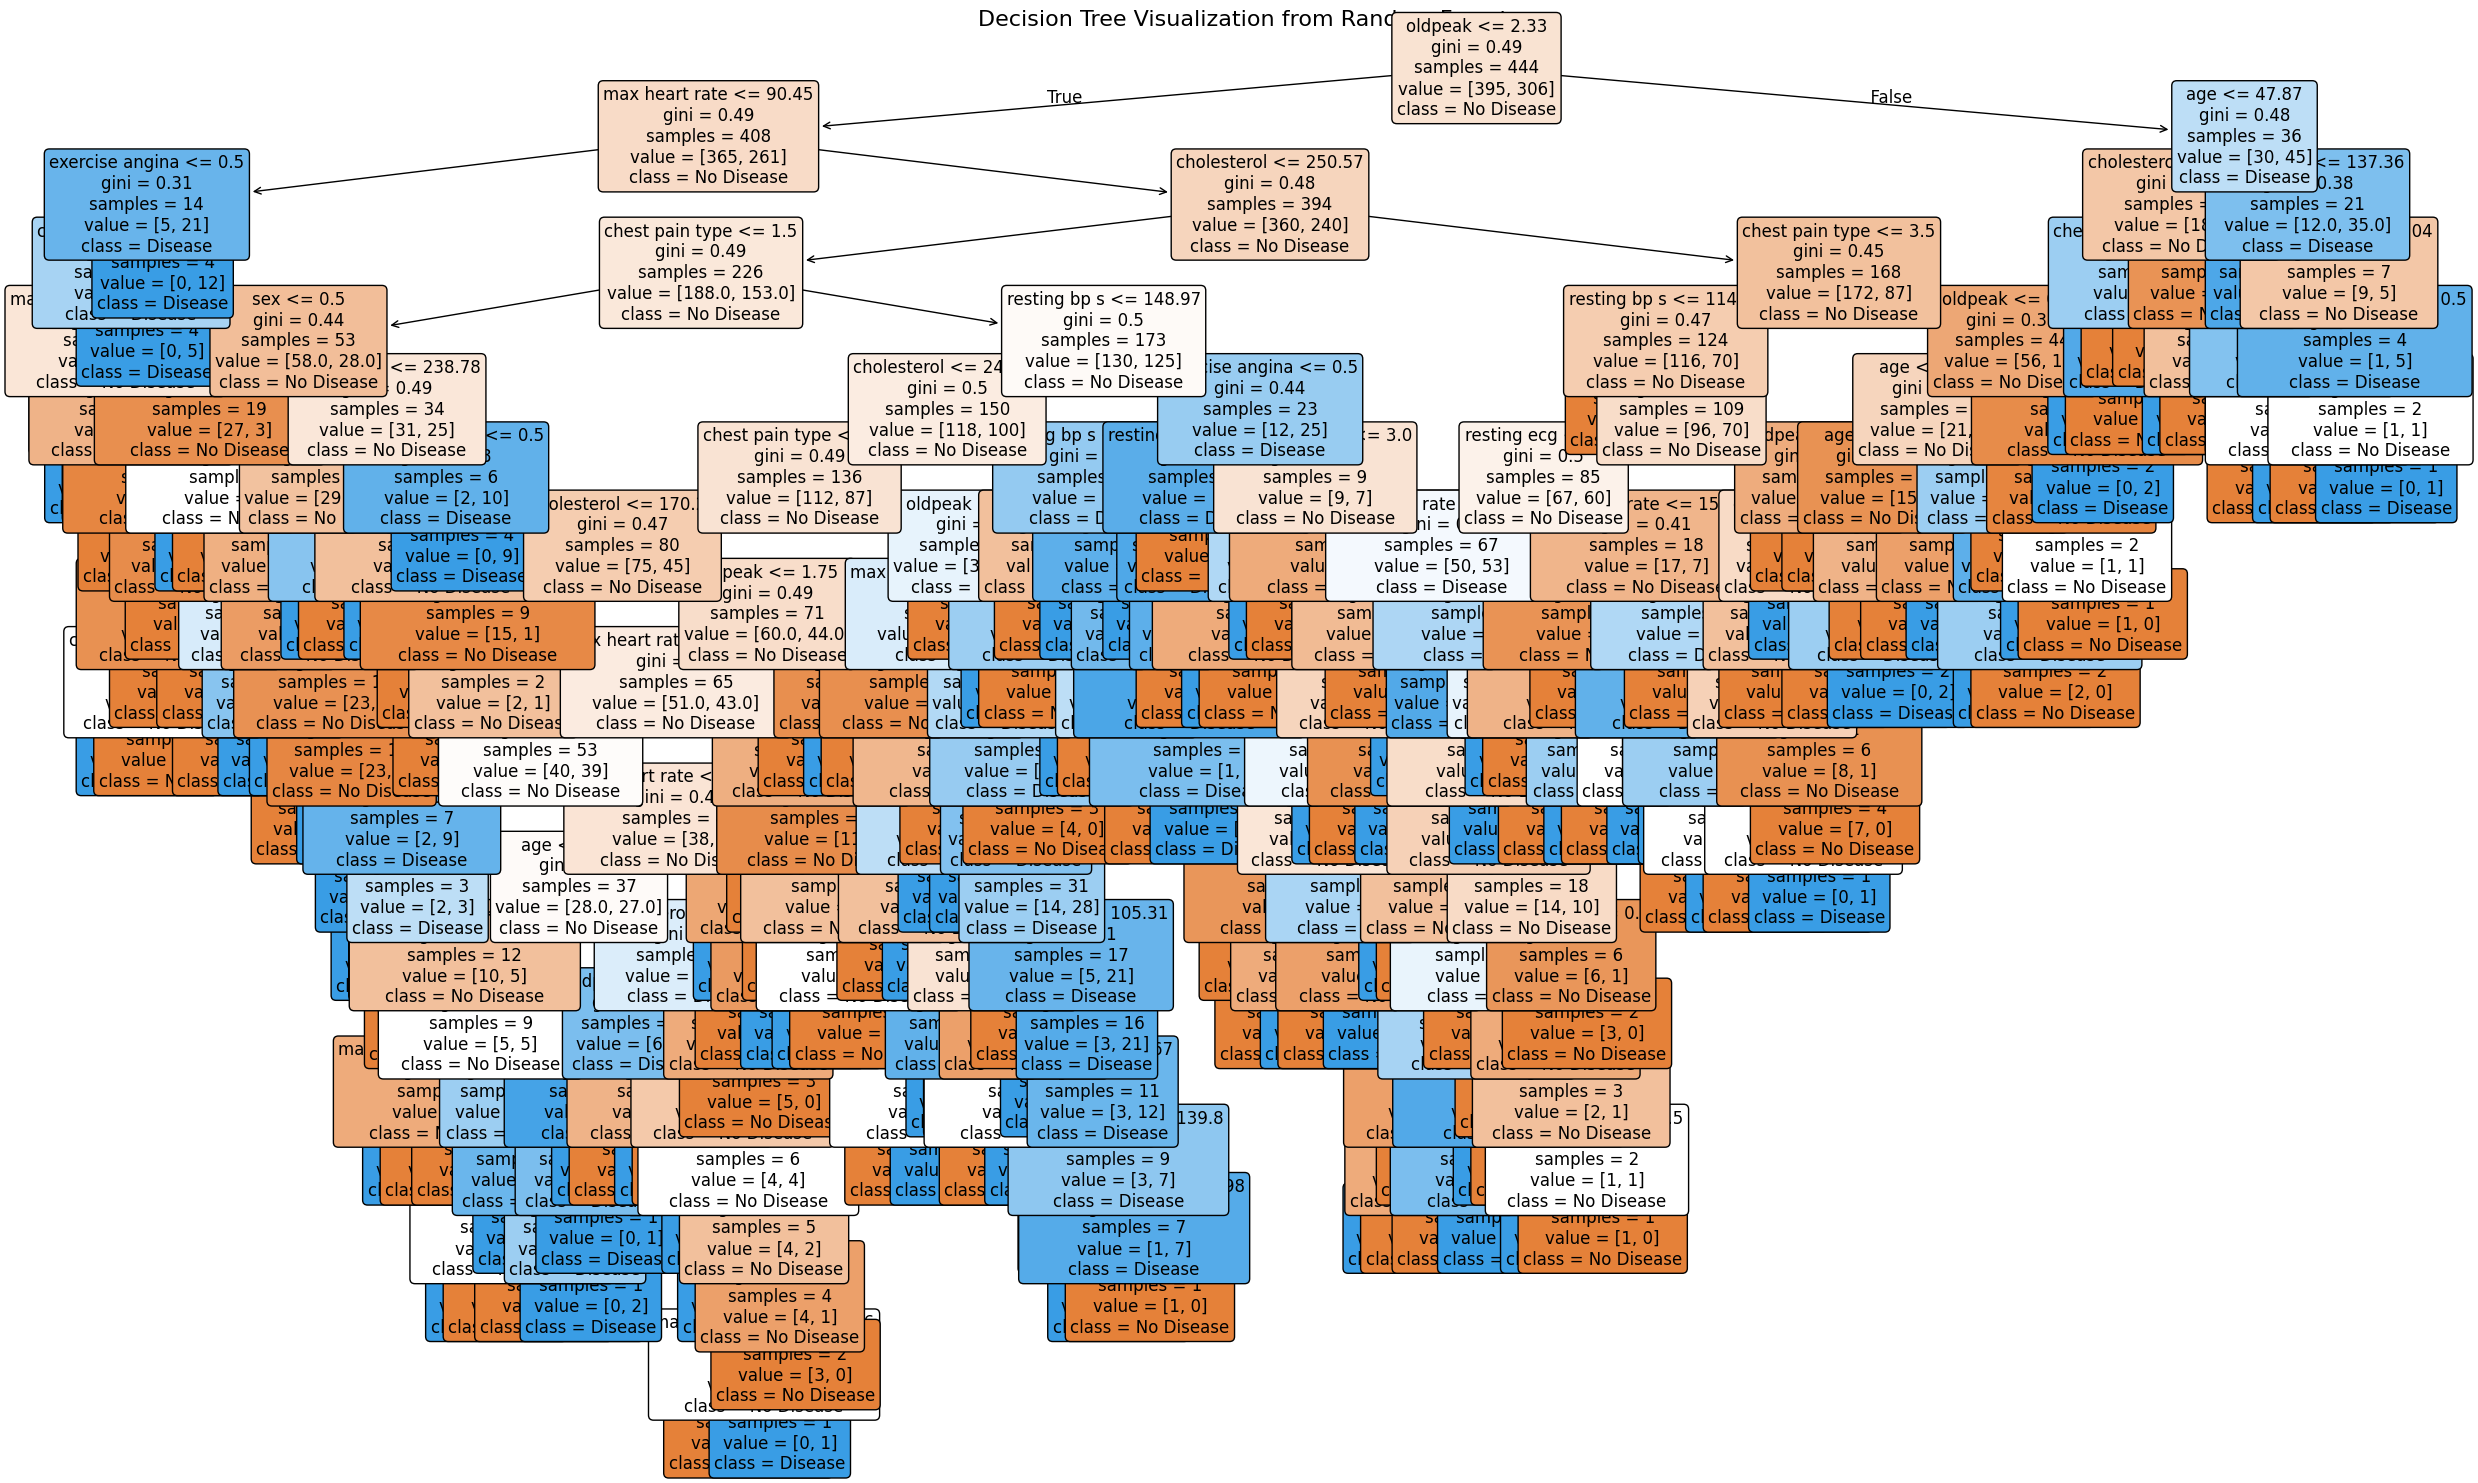

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import plot_tree

# `X` (features) and `y` (target) are already prepared.

# Train Random Forest Model
top_model = RandomForestClassifier(n_estimators=10, random_state=42)
top_model.fit(X, y)

# --- Feature Importance ---
feature_importances = pd.DataFrame({
    "Feature": X.columns,
    "Importance": top_model.feature_importances_
}).sort_values(by="Importance", ascending=True)  # Sorting for better visualization


# --- Visualize a Single Decision Tree ---
single_tree = top_model.estimators_[0]
plt.figure(figsize=(25, 15))
plot_tree(
    single_tree,
    feature_names=X.columns,
    class_names=["No Disease", "Disease"],
    filled=True,
    rounded=True,
    fontsize=12,
    precision=2
)
plt.title("Decision Tree Visualization from Random Forest", fontsize=16)
plt.tight_layout()
plt.show()


|   |   |   |--- chest pain type <= 1.50
|   |   |   |--- chest pain type >  1.50
|   |   |   |   |   |   |--- chest pain type <= 3.50
|   |   |   |   |   |   |--- chest pain type >  3.50
|   |   |   |   |   |   |--- chest pain type <= 3.00
|   |   |   |   |   |   |--- chest pain type >  3.00
|   |   |   |--- chest pain type <= 3.50
|   |   |   |   |   |   |   |   |   |--- chest pain type <= 2.50
|   |   |   |   |   |   |   |   |   |--- chest pain type >  2.50
|   |   |   |--- chest pain type >  3.50
|   |   |   |--- chest pain type <= 3.50
|   |   |   |--- chest pain type >  3.50


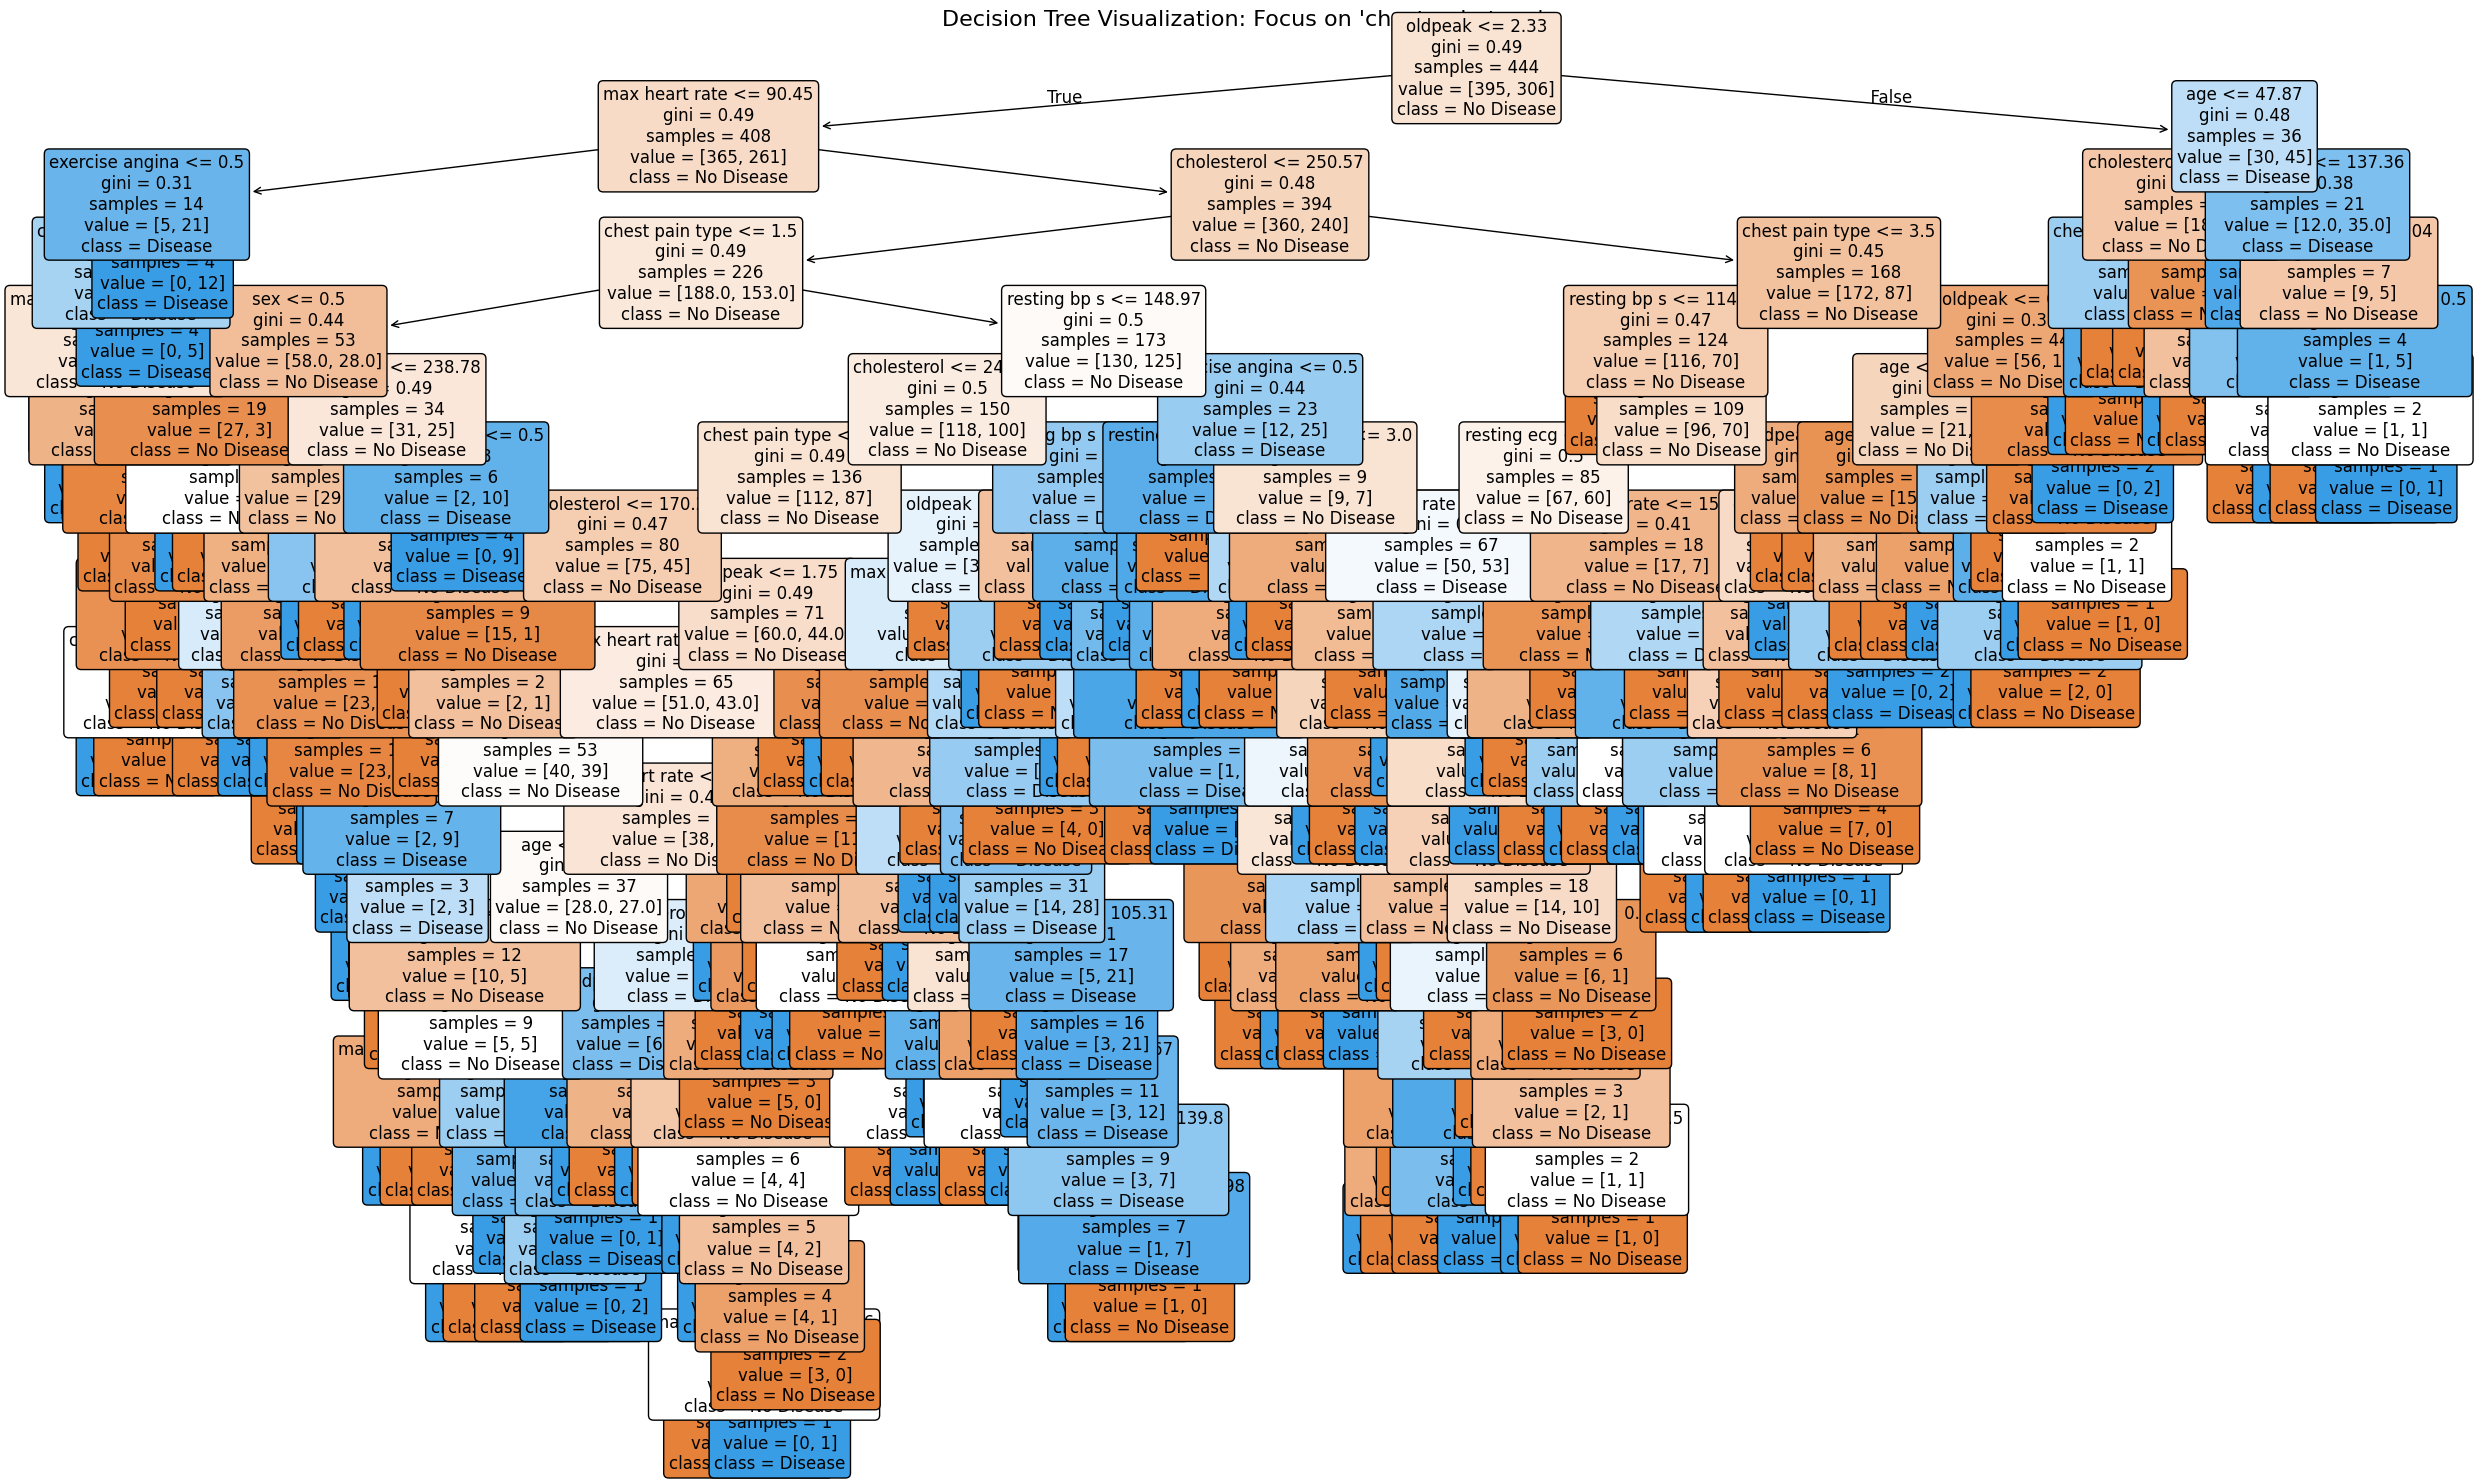

In [ ]:
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_text, plot_tree

# `X` (features) and `y` (target) are already prepared.

# Train Random Forest Model
top_model = RandomForestClassifier(n_estimators=10, random_state=42)
top_model.fit(X, y)

# Select a single tree from the forest
single_tree = top_model.estimators_[0]

# Extract the decision rules where `chest pain type` is used
tree_rules = export_text(single_tree, feature_names=list(X.columns))
chest_pain_rules = [line for line in tree_rules.split("\n") if "chest pain type" in line]

# Print rules related to `chest pain type`
print("\n".join(chest_pain_rules))

# Visualize the entire tree but highlight only splits with `chest pain type`
plt.figure(figsize=(25, 15))
plot_tree(
    single_tree,
    feature_names=X.columns,
    class_names=["No Disease", "Disease"],
    filled=True,
    rounded=True,
    fontsize=12,
    precision=2
)
plt.title("Decision Tree Visualization: Focus on 'chest pain type'", fontsize=16)
plt.tight_layout()
plt.show()


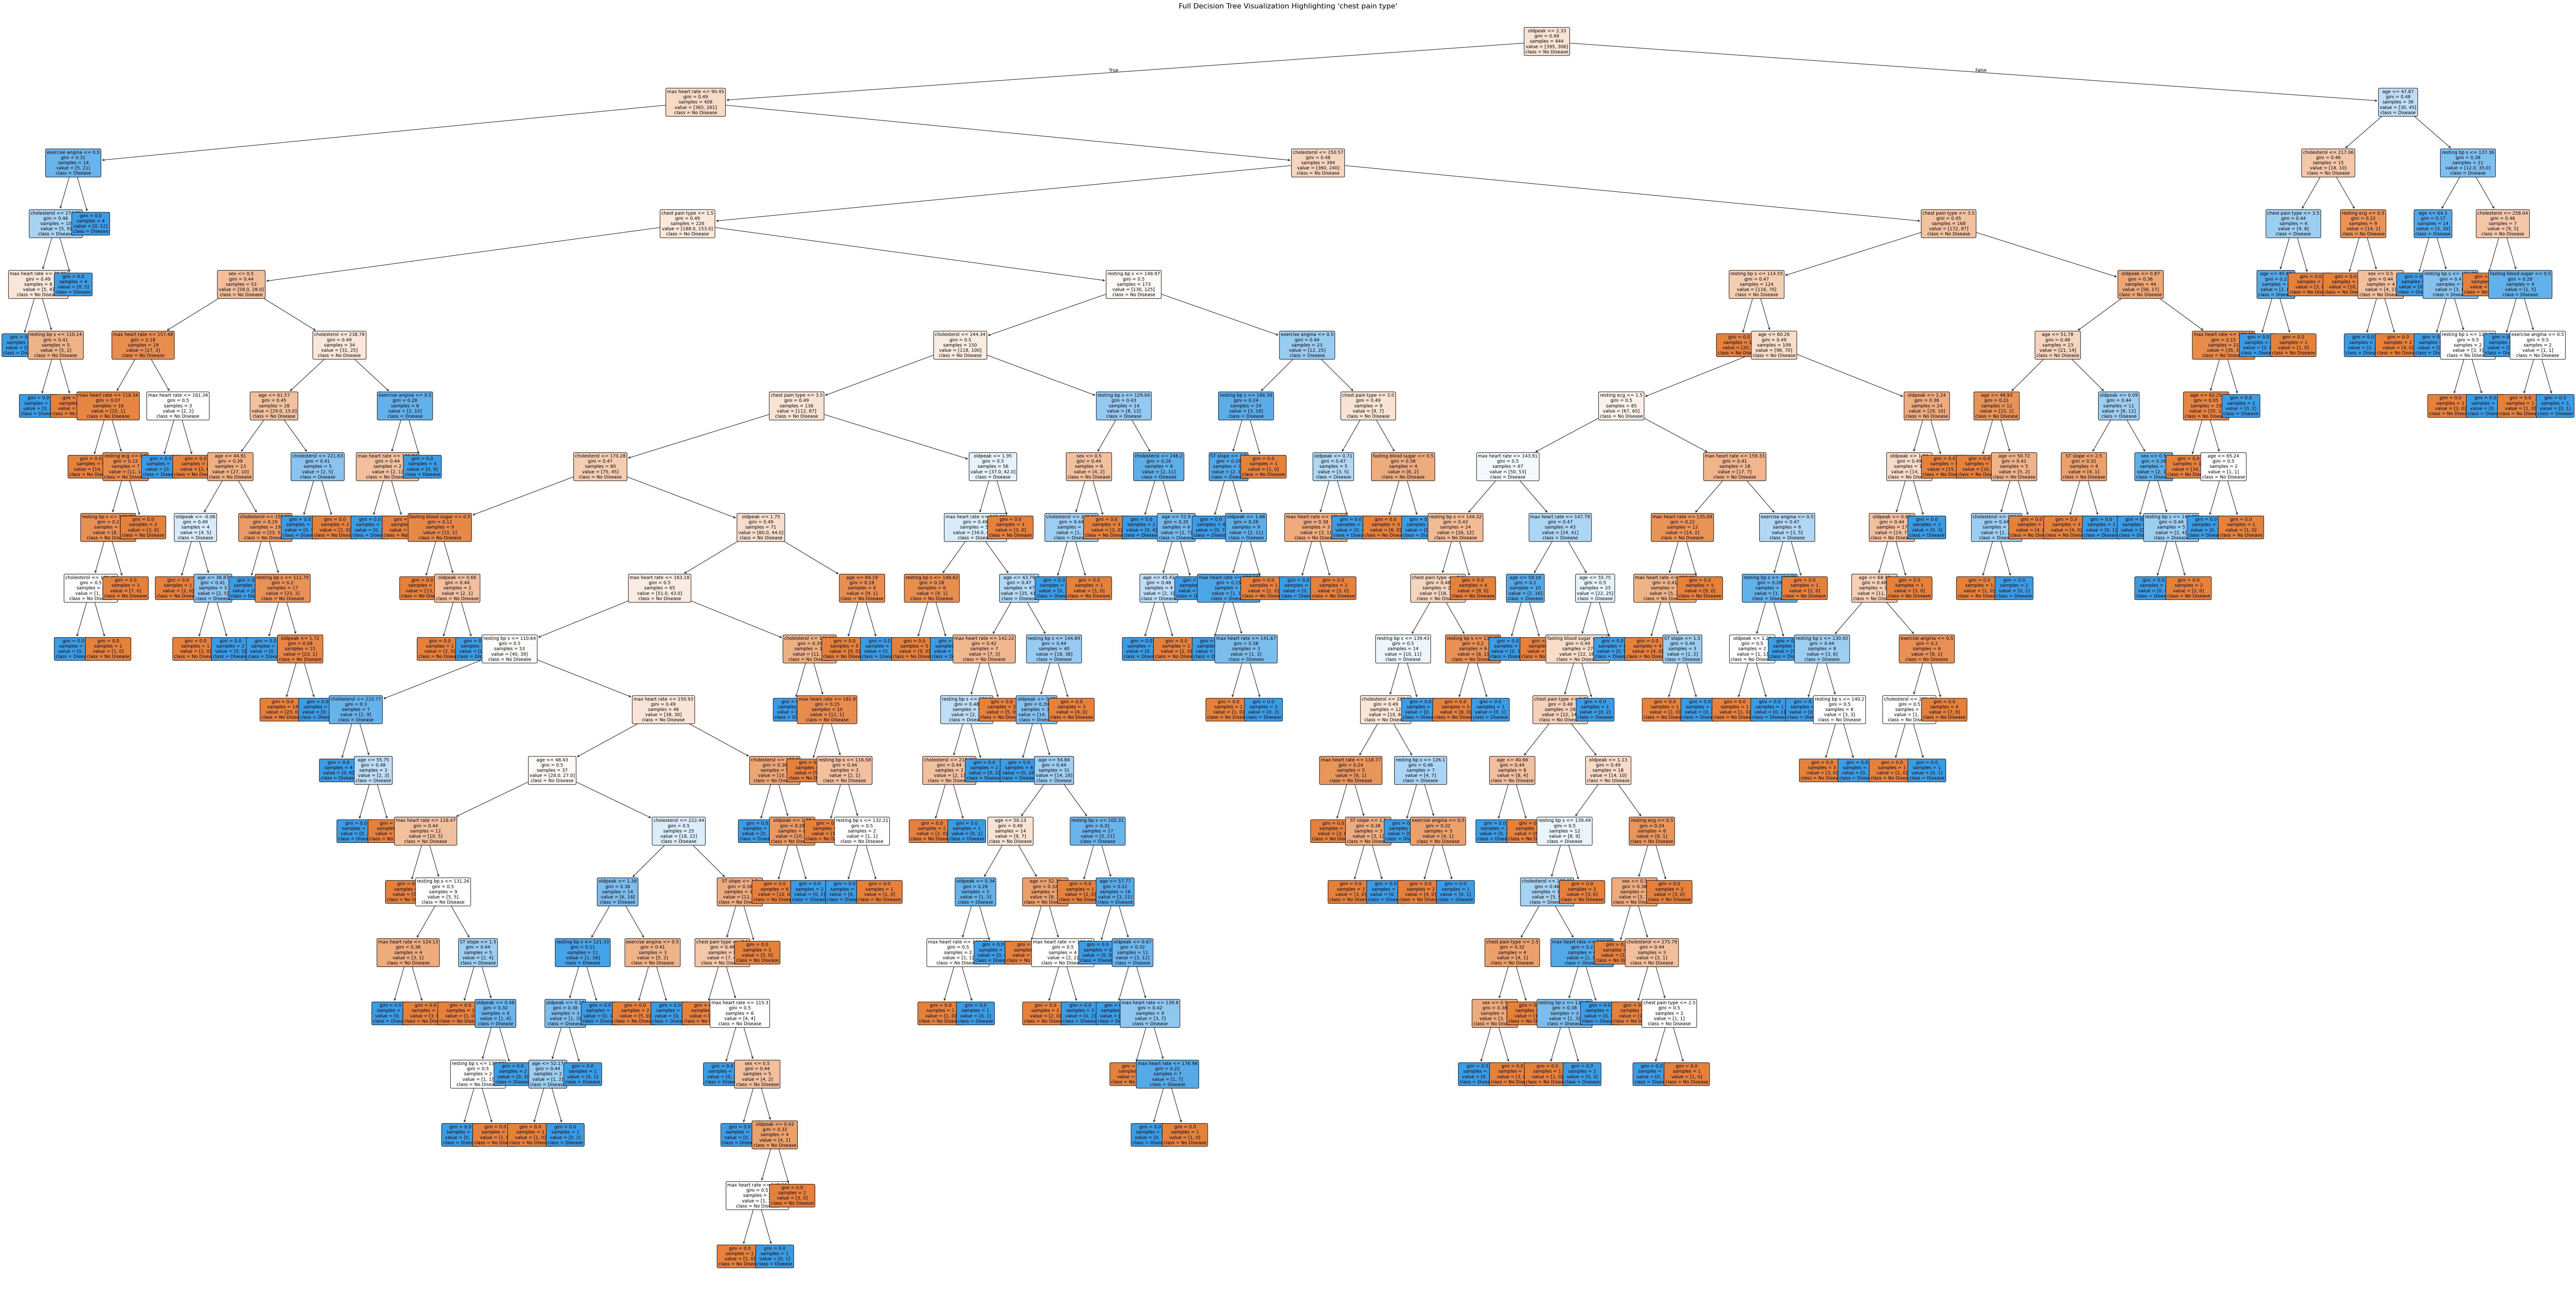

In [ ]:
# MODIFIED

# Import necessary libraries for the task
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Visualize the entire decision tree for the 'chest pain type' feature

# Train a Random Forest model (already done previously)
# Selecting a single decision tree from the Random Forest
single_tree = top_model.estimators_[0]  # Assuming `top_model` is your trained Random Forest

# Increase figure size to handle the full tree
plt.figure(figsize=(80, 40))  # Set larger dimensions for better visibility
plot_tree(
    single_tree,
    feature_names=X.columns,
    class_names=["No Disease", "Disease"],
    filled=True,
    rounded=True,
    fontsize=10,  # Adjust font size for clarity
    precision=2,
    max_depth=None  # Show the entire tree
)

plt.title("Full Decision Tree Visualization Highlighting 'chest pain type'", fontsize=16)
plt.tight_layout()
plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


  0%|          | 0/141 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X

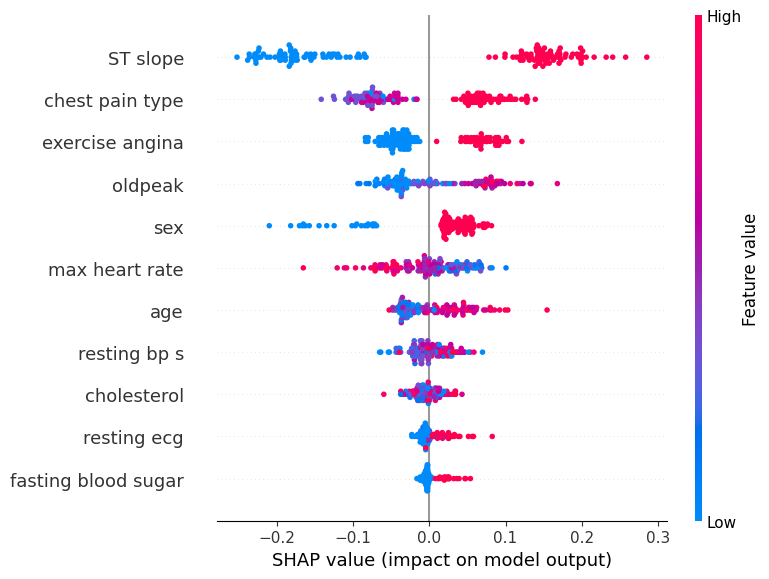

In [ ]:
import shap

# Wrap the Random Forest model's predict function to make it callable
def top_model_predict(X):
    return top_model.predict_proba(X)[:, 1]  # For binary classification

# Initialize SHAP explainer with the callable wrapper
explainer = shap.KernelExplainer(top_model_predict, X_train)
shap_values = explainer(X_test)

# SHAP summary plot to visualize feature impact on model predictions
shap.summary_plot(shap_values, X_test)